In [21]:
# Real case Simulation
# Claudio Iturra, 2024.

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import SeaBreezeModel as sbm
# import taylorDiagram as dia
from scipy.optimize import curve_fit 
import scipy.interpolate as interp

plt.close("all")

(-10.0, 10.0)

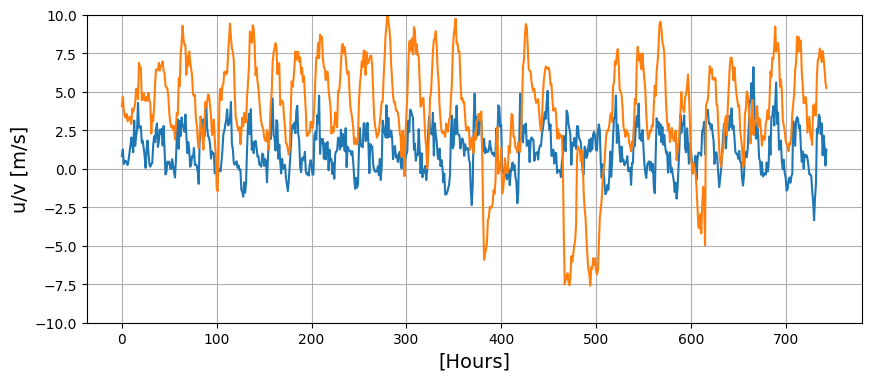

In [23]:
# load  Observations
# =============================================================================
data = pd.read_csv('HUALPENPWIND200501v3.csv',sep=',',header=0)

u_vel = data['u0[m/s]']
v_vel = data['v0[m/s]']
dpdx  = data['dpdx[Pa/km]']
dpdy  = data['dpdy[Pa/km]']

hours = np.arange(len(u_vel))
dpdx_mean = np.mean(dpdx)

plt.rcParams['figure.figsize'] = [10, 4]
plt.figure()
plt.plot(hours,u_vel);
plt.plot(hours,v_vel);

plt.ylabel('u/v [m/s]', fontsize=14) # label along x-axes
plt.xlabel('[Hours]', fontsize=14) # label along x-axes
plt.grid(True)
plt.ylim(-10,10)

(0.0, 11.0)

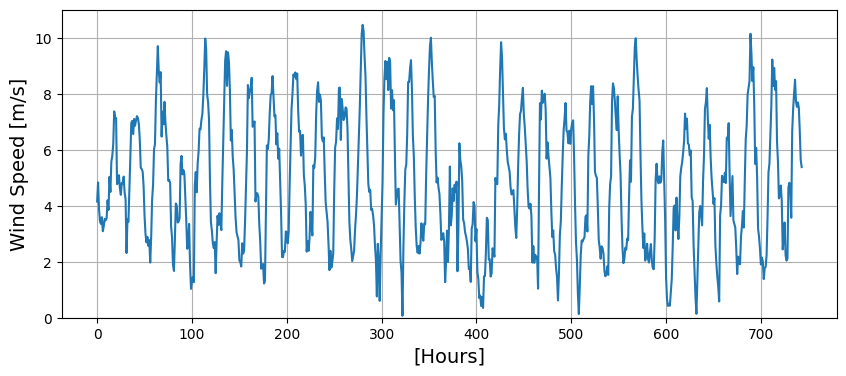

In [24]:
wind_speed = np.sqrt(u_vel**2 + v_vel**2)
plt.rcParams['figure.figsize'] = [10, 4]
plt.figure()
plt.plot(hours,wind_speed)

plt.ylabel('Wind Speed [m/s]', fontsize=14) # label along x-axes
plt.xlabel('[Hours]', fontsize=14) # label along x-axes
plt.grid(True)
plt.ylim(0,11)

In [26]:
# find linear fit to the observed - mean pressure gradient
def linfit(x,a,b):
    return a*x +b

In [27]:
poptlin,pcovlin = curve_fit(linfit,hours, dpdx - dpdx_mean)

dpdx_synoptic = linfit(hours,poptlin[0],poptlin[1]) + dpdx_mean
dpdx_detrend = dpdx - dpdx_synoptic

# interpolation function for the y pressure gradient
f_dpdy = interp.interp1d(np.arange(dpdy.size),dpdy)

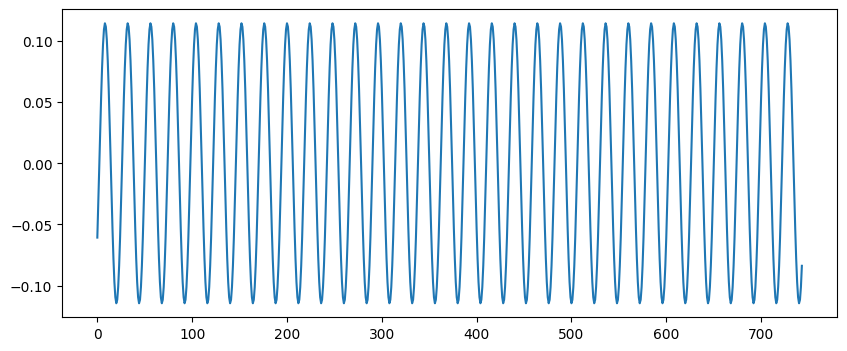

In [30]:
# Estimate A and phi
# =============================================================================

# fit function for daily variations of detrended pressure gradient
def func(hours,A,phase):
    return A/sbm.rho*np.cos(2*np.pi*hours/24.+ phase)

A_guess = 0.05
phase_guess = 0.

popt,pcov = curve_fit(func,hours, dpdx_detrend, p0 = [A_guess,phase_guess],
                      bounds=([0,-np.pi],[5,np.pi])) 

# save estimtas for simulations with the simple idealised model
A_estimate_ideal = popt[0] 
phase_estimate_ideal = popt[1]

plt.plot(hours,func(hours,A_estimate_ideal,phase_estimate_ideal),
         label="fit, A="+ str(round(A_estimate_ideal,2)) + 
         ", $\phi$ ="+str(round(phase_estimate_ideal*180/np.pi,2))+"$^{\circ}$")


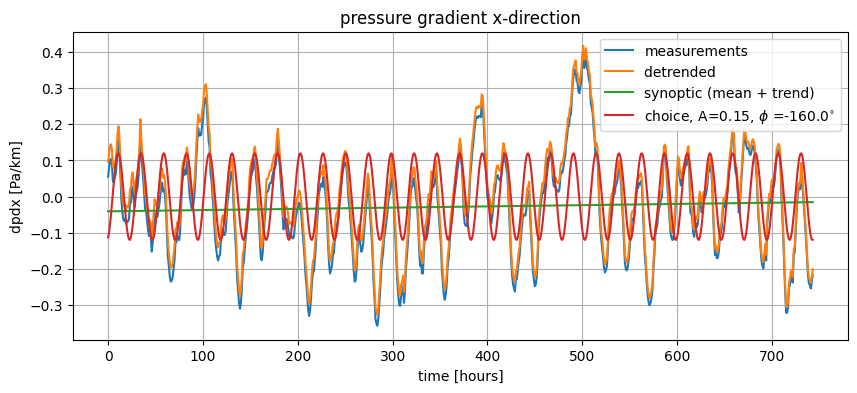

In [37]:
# chosen estimates for the "more sophisticated model"
A_estimate = 0.15
phase_estimate = -160. /180 * np.pi


plt.subplots()
plt.xlabel("time [hours]")
plt.ylabel("dpdx [Pa/km]")
plt.title("pressure gradient x-direction")
plt.plot(hours,dpdx,label="measurements")
plt.plot(hours,dpdx_detrend, label="detrended ")
plt.plot(hours,dpdx_synoptic,label="synoptic (mean + trend)")
 
plt.plot(hours,func(hours,A_estimate,phase_estimate),
         label="choice, A="+ str(round(A_estimate,2)) +
         ", $\phi$ ="+str(round(phase_estimate*180/np.pi,2))+"$^{\circ}$")

plt.legend()
plt.grid()
 

In [38]:
# First guess model
# =============================================================================
# define integration method
dt = 100.
tmax_h = 48 
corrector_step = False
method = "rk4"

integrator = sbm.integration(dt,tmax_h,corrector_step,method)

# define model
lat = 52
A = A_estimate_ideal/1000.   
phase = phase_estimate_ideal 
gamma = 0

In [39]:
# time array
hours_arr = np.linspace(0.,47.,integrator.iters,endpoint=True)

# array of the pressure gradient
dpdx_synoptic = linfit(hours_arr,poptlin[0],poptlin[1]) + dpdx_mean
dpdy = f_dpdy(hours_arr)

# make a model instance with the chosen settings
sb = sbm.seaBreezeModel(lat,A,phase,gamma,dpdx_synoptic/1000., dpdy/1000.)

# initial values for the wind
u_init = u_vel[0]
v_init = v_vel[0]

# integrate the model
integrator.integrate2D(sb.fIdeal,sb.ug, sb.vg, u_init,v_init)

# store variabels
u_model,v_model,time_model = integrator.u,integrator.v, integrator.time   

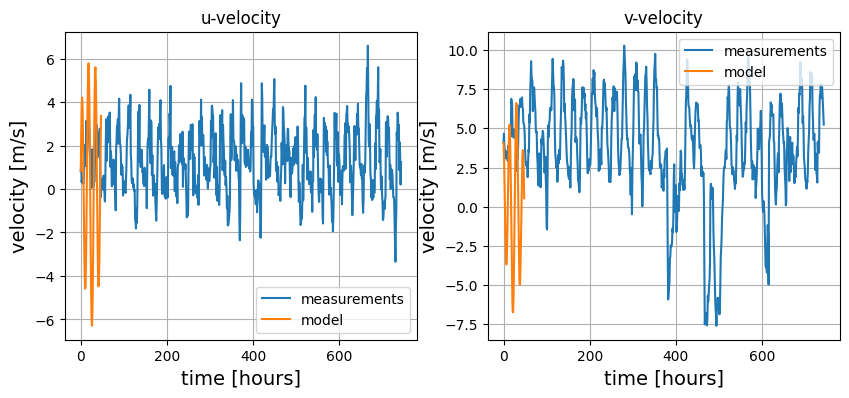

In [40]:
fig, ax = plt.subplots(1,2)
ax[0].set_title("u-velocity")
ax[0].plot(hours,u_vel,label="measurements")
ax[0].plot(time_model[::36]/3600.,u_model[::36],label="model")
ax[0].set_xlabel('time [hours]', fontsize=14) # label along x-axes
ax[0].set_ylabel('velocity [m/s]', fontsize=14) # label along x-axes
ax[0].legend()
ax[0].grid()

ax[1].set_title("v-velocity")
ax[1].plot(hours,v_vel,label="measurements")
ax[1].plot(time_model/3600.,v_model,label="model")
ax[1].set_xlabel('time [hours]', fontsize=14) # label along x-axes
ax[1].set_ylabel('velocity [m/s]', fontsize=14) # label along x-axes
ax[1].legend()
ax[1].grid()
